In [1]:
# Cailbrate Camera Images using Checkerboard Pattern - Zack H

In [2]:
'''
camera calibration for distorted images with chess board samples
reads distorted images, calculates the calibration and write undistorted images
usage:
    calibrate.py [--debug <output path>] [--square_size] [<image mask>]
default values:
    --debug:    ./output/
    --square_size: 1.0
    <image mask> defaults to ../data/left*.jpg
'''

# Python 2/3 compatibility
from __future__ import print_function
import os
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import getopt
from glob import glob

In [3]:
#Functions
def splitfn(fn):
    path, fn = os.path.split(fn)
    name, ext = os.path.splitext(fn)
    return path, name, ext

def processImage(fn):
    print('processing %s... ' % fn)
    img = cv.imread(fn, 0)
    if img is None:
        print("Failed to load", fn)
        return None

    assert w == img.shape[1] and h == img.shape[0], ("size: %d x %d ... " % (img.shape[1], img.shape[0]))
    found, corners = cv.findChessboardCorners(img, pattern_size)
    if found:
        term = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 30, 0.1)
        cv.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if odir:
        vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        cv.drawChessboardCorners(vis, pattern_size, corners, found)
        _path, name, _ext = splitfn(fn)
        outfile = os.path.join(odir, name + '_chess.png')
        cv.imwrite(outfile, vis)

    if not found:
        print('chessboard not found')
        return None

    print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

In [4]:
#Vars
wdir = "I:\Summer 2019\Capstone\CaliImg"
odir = wdir + "\out"
img_mask = wdir + "\checker.png"
square_size =  1
threads_num = 4
pattern_size = (15, 7) #Interior Number of black square corners

Run with 4 threads...
processing I:\Summer 2019\Capstone\CaliImg\checker.png... 
           I:\Summer 2019\Capstone\CaliImg\checker.png... OK

RMS: 0.8360959580605704
camera matrix:
 [[1.14750792e+03 0.00000000e+00 8.85927124e+02]
 [0.00000000e+00 1.11108377e+03 5.87123970e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [-0.35705161  0.11872496 -0.02319258  0.00595891  0.0026335 ]

Undistorted image written to: I:\Summer 2019\Capstone\CaliImg\out\checker_undistorted.png

--- Original Image:


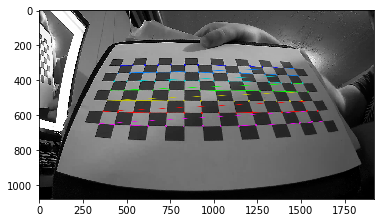

--- Transformed Image:


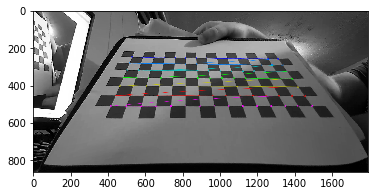

Done


In [5]:
# Find Transformation Matrix to Undistort Checkerboard, outputs Test images

img_names = glob(img_mask)
if odir and not os.path.isdir(odir):
    os.mkdir(odir)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv.imread(img_names[0], cv.IMREAD_GRAYSCALE).shape[:2]  # TODO: use imquery call to retrieve results

if threads_num <= 1:
    chessboards = [processImage(fn) for fn in img_names]
else:
    print("Run with %d threads..." % threads_num)
    from multiprocessing.dummy import Pool as ThreadPool
    pool = ThreadPool(threads_num)
    chessboards = pool.map(processImage, img_names)

chessboards = [x for x in chessboards if x is not None]
for (corners, pattern_points) in chessboards:
    img_points.append(corners)
    obj_points.append(pattern_points)

# calculate camera distortion
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

# undistort the image with the calibration
print('')
for fn in img_names if odir else []:
    path, name, ext = splitfn(fn)
    img_found = os.path.join(odir, name + '_chess.png')
    outfile = os.path.join(odir, name + '_undistorted.png')

    img = cv.imread(img_found)
    if img is None:
        continue

    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))

    #dst = cv.undistort(img, camera_matrix, dist_coefs, None, newcameramtx) #with cv.undistort
    
    mapx, mapy = cv.initUndistortRectifyMap(camera_matrix, dist_coefs, None, newcameramtx, (w,h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR) #with cv.remap
    
    #print("dst",dst) #DEBUG
    #print("img",img)
    if dst is None:
        print("WARNING - Undistorted Image is empty")    
    #plt.imshow(dst); #DEBUG
    #plt.show()  
    
    # crop and save the image if corners were detected    
    if roi == (0,0,0,0):
        print("\n*** WARNING: No corners were detected and image will not be cropped, weird stuff might happen.\n")
    else:
        x, y, w, h = roi
        #print("DEBUG: y",y,", y+h",y+h,", x",x,", x+w",x+w)
        dst = dst[y:y+h, x:x+w]
    

    print('Undistorted image written to: %s' % outfile)
    cv.imwrite(outfile, dst)

print("\n--- Original Image:")
plt.imshow(img); 
plt.show()  
print("--- Transformed Image:")
plt.imshow(dst); 
plt.show()

print('Done')

In [6]:
# Now apply Transformation to all images in Target Directory

#Vars
#tdir = "F:\\frames"
tdir = "I:\\Summer 2019\\Capstone\\Frames-DemoTest\\demo-5"
otdir = tdir + "\\demo5-calibrated\\"

In [7]:
# Transforming target Images

if otdir and not os.path.isdir(otdir):
    os.mkdir(otdir)

directory = os.fsencode(tdir)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    #print(filename)
    img = cv.imread(tdir + "\\" + filename)
    if img is None:
        continue
    h, w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
    dst = cv.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)
    #print("dst",dst) #DEBUG
    #print("img",img)
    if dst is None:
        print("WARNING - Undistorted Image is empty")    
    #plt.imshow(dst); #DEBUG
    #plt.show()      
    # crop and save the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    print('Undistorted image written to: %s' % otdir+filename)
    cv.imwrite(otdir+filename, dst)

Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000159.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000160.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000161.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000162.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000163.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000164.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000165.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\output_0000166.jpg
Undistorted image written to: I:\Summer 2019\Capstone\Frames-DemoTest\demo-5\demo5-calibrated\ou